In [2]:
# preparation
import matplotlib.pyplot as plt


在之前的章节中，我们研究了一系列不同的模型用于解决分类问题和回归问题。经常发现的一件事情是，我们可以通过以某种方式将多个模型结合到一起的方法来提升性能，而不是独立的使用一个单独的模型。例如，我们可以训练L个不同的模型，然后使用每个模型给出的预测的平均值进行预测。这样的模型的组合有时被称为委员会（committee）。在14.2节，我们讨论在实际问题中使用委员会概念的方式，我们也会给出一些深刻的认识，来理解它为什么有时会 是一个有效的方法。

委员会方法的一个重要的变体，被称为提升方法（boosting）。这种方法按顺序训练多个模型，其中用来训练一个特定模型的误差函数依赖于前一个模型的表现。与单一模型相比，这个模型可以对性能产生显著的提升，将在14.3节讨论。

与对一组模型的预测求平均的方法不同，另一种形式的模型组合是选择一个模型进行预测，其中模型的选择是输入变量的一个函数。因此不同的模型用于对输入空间的不同的区域进行预 测。这种方法的一种广泛使用的框架被称为决策树（decision tree），其中选择的过程可以被描述为一个二值选择的序列，对应于对树结构的遍历，将在14.4节讨论。这种情况下，各个单独的模型通常被选得非常简单，整体的模型灵活性产生于与输入相关的选择过程。决策树既可以应 用于分类问题也可以应用于回归问题。

决策树的一个局限性是对于输入空间的划分基于的是一种硬划分，对于输入变量的任意给定的值，只有一个模型用于做出预测。通过将一个概率框架用于模型组合，决策的过程可以被软化，将在14.5节讨论。例如，如果我们有一组K个模型用于描述条件概率分布$ p(t|x,k) $，其中$ x $是输入变量，$ t $是目标变量，$ k = 1,...,K $是模型的索引，那么我们可以进行一种概率形式的混合，形式为
$ p(t|x) = \sum\limits_{k=1}^K\pi_k(x)p(t|x,k) \tag{14.1} $
其中$ \pi_k(x) = p(k|x) $表示与输入相关的混合系数。这样的模型可以被看成混合概率分布，其中分量的概率密度以及混合系数都以输入变量为条件，被称为专家混合（mixture of experts）。这种模型与5.6节讨论的混合密度网络密切相关。




# 14.1 贝叶斯模型平均

将模型组合方法与贝叶斯模型平均方法区分开是很重要的，这两种方法经常被弄混淆。为了理解二者的差异，考虑使用高斯混合模型进行概率密度估计的例子，其中若干的高斯分量以概率的方式进行组合。模型包含一个二值潜在变量$ z $，它表示混合分布中的哪个分量用于生成对应的数据点。因此，模型通过联合概率分布
$ p(x,z) \tag{14.2} $
进行具体化，观测变量x上的对应的概率密度通过对潜在变量求和的方式得到，即
$ p(x) = \sum\limits_zp(x,z) \tag{14.3} $
在我们的高斯混合模型的例子中，这会得到一个概率分布，形式为
$ p(x) = \sum\limits_{k=1}^K\pi_k\mathcal{N}(x|\mu_k,\Sigma_k) \tag{14.4} $
各个符号的含义与之前相同。这是模型组合的一个例子。对于独立同分布的数据，我们可以使用式（14.3）将数据集$ X = {x_1,...,x_N} $的边缘概率写成下面的形式
$ p(X) = \prod\limits_{n=1}^Np(x_n) = \prod\limits_{n=1}^N\left[\sum\limits_{z_n}p(x_n,z_n)\right] \tag{14.5} $
因此我们看到，每个观测数据点$ x_n $有一个对应的潜在变量$ z_n $。

现在假设我们有若干个不同的模型，索引为$ h = 1,...,H $，先验概率分布为$ p(h) $。例如，一个模型可能是高斯混合模型，另一个模型可能是柯西分布的混合。数据集上的边缘概率分布为
$ p(X) = \sum\limits_{h=1}^Hp(X|h)p(h) \tag{14.6} $
这是贝叶斯模型平均的一个例子。这个在$ h $上的求和式的意义是，只有一个模型用于生成整个数 据集，$ h $上的概率分布仅仅反映了我们对于究竟是哪个模型用于生成数据的不确定性。随着数据集规模的增加，这个不确定性会减小，后验概率分布$ p(h|X) $会逐渐集中于模型中的某一个。

这就强调了贝叶斯模型平均和模型组合的一个关键的不同，因为在贝叶斯模型平均中，整个数据集由单一的模型生成。相反，当我们像（14.5）那样组合多个模型时，我们看到数据集中的 不同的数据点可以由潜在变量$ z $的不同的值生成，即由不同的分量生成。

虽然我们研究的是边缘概率分布$ p(X) $，但是同样的讨论适用于预测分布$ p(x|X) $以及诸如$ p(t|x,X, T) $这样的条件概率分布。



# 14.2 委员会

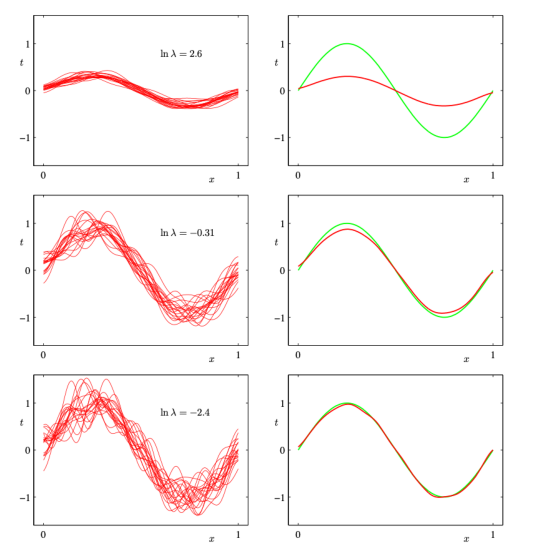

In [4]:
# 图3.5
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图3.5.png')
plt.axis('off')
ax.imshow(d)

构建一个委员会的最简单的方法是对一组独立的模型的预测取平均。这样的方法的动机可以从频率学家的观点看出来。这种观点考虑偏置和方差之间的折中，它将模型的误差分解为偏置分量和方差分量，其中偏置分量产生于模型和真实的需要预测的函数之间的差异，方差分量表示模型对于单独的数据点的敏感性。回忆一下，根据图3.5，当我们使用正弦数据训练多个多项式函数，然后对得到的函数求平均时，来自方差项的贡献倾向于被抵消掉，从而产生了预测的提升。当我们对一组低偏置的模型（对应于高阶多项式）求平均时，我们得到的对用于生成数 据的正弦函数的精确的预测。

当然，在实际应用中，我们只有一个单独的数据集，因此我们必须寻找一种方式来表示委员 会中不同模型之间的变化性。一种方法是使用1.2.3节讨论的自助（bootstrap）数据集。考虑一个 回归问题，其中我们试图预测一个连续变量的值，并且假设我们生成了$ M $个自助数据集然后使用每个数据集训练处了预测模型的一个独立的副本$ y_m(x) $，其中$ m = 1,...,M $。委员会预测为
$ y_{COM}(x) = \frac{1}{M}\sum\limits_{m=1}^My_m(x) \tag{14.7} $
这个方法被称为自助聚集（bootstrap aggregation）或者打包（bagging）（Breiman， 1996）。
假设我们试图预测的真实的回归函数为$ h(x) $，从而每个模型的输出可以写成真实值加上误差的形式，即
$ y_m(x) = h(x) + \epsilon_m(x) \tag{14.8} $
这样，平方和误差函数的形式为
$ \mathbb{E}_x[{y_m(x) - h(x)}^2] = \mathbb{E}_x[\epsilon_m(x)^2] \tag{14.9} $
其中$ \mathbb{E}_x[\dot] $表示关于输入向量$ x $的一个频率学的期望。于是，各个模型独立预测的平均误差为
$ E_{AV} = \frac{1}{M}\sum\limits_{m=1}^M\mathbb{E}_x[\epsilon_m(x)^2] \tag{14.10} $
类似的，委员会方法的预测（14.7）的期望误差为
$ \begin{eqnarray} E_{COM} &=& \mathbb{E}x\left[\left{\frac{1}{M}\sum\limits{m=1}^My_m(x) - h(x)\right}^2\right] \\ &=& \mathbb{E}x\left[\left{\frac{1}{M}\sum\limits{m=1}^M\epsilon_m(x)\right}^2\right] \tag{14.11} \end{eqnarray} $
如果我们假设误差的均值为0，且不具有相关性，即
$ \begin{eqnarray} \mathbb{E}_x[\epsilon_m(x)] &=& 0 \tag{14.12} \\ \mathbb{E}_x[\epsilon_m(x)\epsilon_l(x)] &=& 0 , m \neq l \tag{14.13} \end{eqnarray} $
那么我们有
$ E_{COM} = \frac{1}{M}E_{AV} \tag{14.14} $
这个显然具有戏剧性的结果表明，一个模型的平均误差可以仅仅通过对模型的$ M $个版本求平均的方式减小$ M $倍。不幸的是，它依赖于我们的关键假设，即由各个单独的模型产生的误差是不相关的。在实际应用中，误差通常是高度相关的，因此整体的误差下降是通常是很小的。然而，可以证明，委员会误差的期望不会超过各个分量模型的期望误差，即$ E_{COM} \leq E_{AV} $。为了得到更显著的提升，我们转向一种更加复杂的构建委员会的方法，被称为提升方法。



# 14.3 提升方法

提升方法是一种很强大的方法，它将多个“基”分类器进行组合，产生一种形式的委员会，委员会的表现会比任何一个基分类器的表现好得多。这里，我们介绍提升方法的最广泛使用的 一种形式，被称为AdaBoost，是“可调节提升方法（adaptive boosting）”的简称，由Freund and Schapire（1996）提出。即使基分类器的表现仅仅比随机猜测的表现稍好，提升方法仍可以产生比较好的结果。这种基分类器有时被称为弱学习器（weak learner）。提升方法最初被用来解决 分类问题，但是也可以推广到回归问题（Friedman， 2001）。

提升方法和委员会方法（例如上面讨论的打包方法）的主要不同在于，基分类器是顺序训练的，每个基分类器使用数据集的一个加权形式进行训练，其中与每个数据点相关联的权系数依赖于前一个分类器的表现。特别地，被一个基分类器误分类的点在训练序列中的下一个分类器时会被赋予更高的权重。一旦所有的分类器都训练完毕，那么它们的预测就会通过加权投票的 方法进行组合，如图14.1所示。

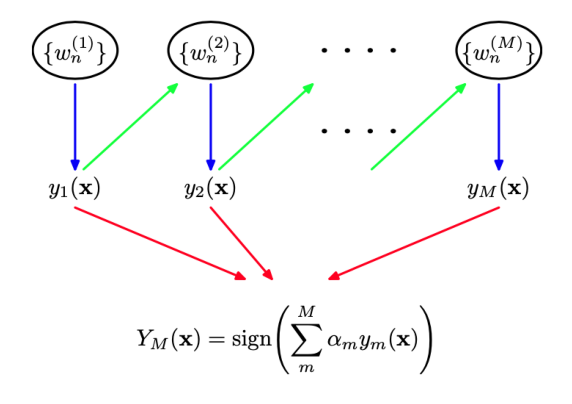

In [5]:
# 图14.1
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图14.1.png')
plt.axis('off')
ax.imshow(d)

图 14.1 提升方法框架的图形表示。每个基分类器$ y_m(x) $都在训练数据集的一个加权形式（蓝色箭头）上进行训练，权值$ w_n^{(m)} $依赖于前一个基分类器$ y_{m-1}(x) $（绿色箭头）的表现。一旦所有的基分类器训练完毕，它们被组合得到最终的分类器$ Y_M(x) $（红色箭头）。

考虑一个二分类问题，其中训练数据由输入向量$ x_1,...,x_N $以及对应的二值目标变量$ t_1,...,t_N $组成，其中$ t_n \in {−1,1} $。每个数据点被赋予了一个关联的权值参数$ w_n $，对于所有的数据点，它都被初始化为$ 1 / N $。我们假设我们有一个使用加权数据训练基分类器的方法，得到函数$ y(x) \in {−1,1} $。在算法的每个阶段，AdaBoost使用一个数据集训练一个新的分类器，其中权系数根据前一个训练的分类器的表现进行调节，从而为误分类的数据点赋予更高的权值。最后，当我们训练了所需数量的基分类器之后，它们进行组合，形成一个委员会，组合的系数会为不同的基分类器赋予不同的权值。AdaBoost算法的精确形式叙述如下。

- 初始化数据加权系数$ {w_n} $，方法是对$ n = 1,...,N $，令$ w_n^{(1)} = 1 / N $。
- 对于$ m = 1,...,M $：

-使用训练数据调节一个分类器$ y_m(x) $，调节的目标是最小化加权的误差函数
$ J_m = \sum\limits_{n=1}^Nw_n^{(m)}I(y_m(x_n) \neq t_n) \tag{14.15} $
其中$ I(y_m(x_n) \neq t_n）$是一个示性函数，当$ y_m(x_n) \neq t_n $时，值为1，其他情况下值为0。

-计算
$ \epsilon_m = \frac{\sum\limits_{n=1}^N w_n^{(m)}I(y_m(x_n) \neq t_n)}{\sum\limits_{n=1}^N w_n^{(m)}} \tag{14.16} $
然后计算
$ \alpha_m = \ln\left{\frac{1-\epsilon_m}{\epsilon_m}\right} \tag{14.17} $

-更新数据权系数
$ w_n^{(m+1)} = w_n^{(m)}exp{\alpha_mI(y_m(x_n) \neq t_n)} \tag{14.18} $

- 使用最终的模型进行预测，形式为
$ Y_M(x) = sign\left(\sum\limits_{m=1}^M\alpha_my_m(x)\right) \tag{14.19} $

我们看到第一个基分类器$ y_1(x) $使用全部相等的加权系数$ w_n^{(1)} $进行训练，因此它对应于训练单一的分类器的通常的步骤。根据（14.18），我们看到在后续的迭代过程中，权系数$ w_n^{(m)} $对于误分类的数据点会增大，对于正确分类的数据点不改变。因此后续的分类器就会更关注那些被前一个分类器错误分类的数据点。$ \epsilon_m $表示每个基分类器在数据集上的错误率的加权度量。于是我们看到式（14.17）定义的权系数$ \alpha_m $会在计算整体输出（14.19）时，为更准确的分类器赋予更高的权值。

AdaBoost算法如图14.2所示，数据集是图A.7所示的分类数据集的由30个数据点组成的子集。

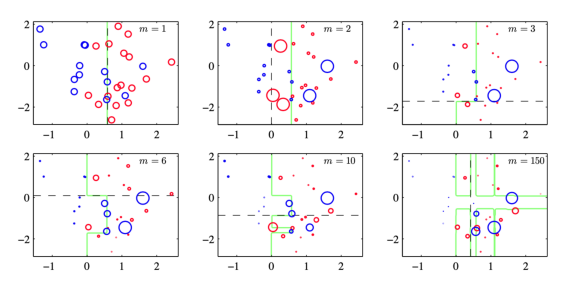

In [6]:
# 图14.2
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图14.2.png')
plt.axis('off')
ax.imshow(d)


 
图 14.2 提升方法的说明,其中基学习器由作用于某个轴的简单的阈值组成。每张图给出了目前训练的基学习器的数量$ m $，以及最近的基学习器的决策边界（黑色虚线）和组合的决策边界（绿色实线）。每个数据点用圆圈表示，它的半径表示在训练最近添加的基学习器时数据点的权值。因此，例如，我们看到被$ m = 1 $的学习器误分类的点在训练$ m = 2 $的学习器时被赋予了更高的权值。

这里，每个基分类器由一个输入变量的阈值组成。这个简单的分类器对应于一种被称为“决策树桩”的决策树形式，即一个具有单结点的决策树。因此，每个基学习器根据一个输入特征是否超 过某个阈值对输入进行分类，因此仅仅使用一个与一个坐标轴垂直的线性决策面将空间划分为 两个区域。



## 14.3.1 最小化指数误差

提升方法最早起源于统计学习理论，得到了泛化误差的上界。然而，这些上界过于宽松，没有实际的价值。提升方法的实际表现要远优于上界给出的值。Friedman et al.(2000)根据对一个指数误差函数的顺序最小化，给出了提升方法的一个不同的且非常简单的表述。
考虑下面定义的指数误差函数
$ E = \sum\limits_{n=1}^Nexp{-t_nf_m(x_n)} \tag{14.20} $
其中$ f_m(x) $是一个根据基分类器$ y_l(x) $的线性组合定义的分类器，形式为
$ f_m(x) = \frac{1}{2}\sum\limits_{l=1}^m\alpha_ly_l(x) \tag{14.21} $
$ t_n \in {−1, 1} $是训练集目标值。我们的目标是关于权系数$ \alpha_l $和基分类器$ y_l(x) $最小化$ E $。

然而，我们不进行误差函数的全局最小化，而是假设基分类器$ y_1(x),...,y_{m−1}(x) $以及它们的系数$ \alpha_1,...,\alpha_{m−1} $固定，因此我们只关于$ \alpha_m $和$ y_m(x) $进行最小化。分离出基分类器$ y_m(x) $的贡献，我们可以将误差函数写成

$ \begin{eqnarray} E &=& \sum\limits_{n=1}^N exp\left{-t_nf_{m-1}(x_n) - \frac{1}{2}t_n\alpha_my_m(x_n)\right} \\ &=& \sum\limits_{w_n^{(m)}}exp\left{-\frac{1}{2}t_n\alpha_my_m(x_n)\right} \tag{14.22} \end{eqnarray} $

其中，系数$ w_n^{(m)} = exp{−t_nf_{m-1}(x_n)} $可以被看做常数，因为我们只针对$ \alpha_m $和$ y_m(x) $进行最如果我们将被$ y_m(x) $正确分类的数据点的集合记作$ T_m $，并且将剩余的误分类的点记作$ M_m $，那么我们可以将误差函数写成下面的形式

$ \begin{eqnarray} E &=& e^{-\alpha_m / 2}\sum\limits_{n \in T_m}w_n^{(m)}e^{\alpha_m / 2}\sum\limits_{n \in M_m}w_n^{(m)} \\ &=& (e^{\alpha_m / 2} - e^{-\alpha_m / 2})\sum\limits_{n=1}^Nw_n^{(m)}I(y_m(x_n) \neq t_n) + e^{-\alpha_m / 2}\sum\limits_{n=1}^Nw_n^{(m)} \tag{14.23} \end{eqnarray} $

当我们关于$ y_m(x) $进行最小化时，我们看到第二项是常数，因此这等价于对（14.15）进行最小化，因为在求和式前面的整个可乘性因子不影响最小值的位置。类似地，关于$ \alpha_m $最小化，我们得到了式（14.17），其中$ \epsilon_m $由式（14.16）定义。

根据式（14.22），我们看到，找到$ \alpha_m $和$ y_m(x) $之后，数据点的权值使用下面的公式进行更新

$ w_n^{(m+1)} = w_n^{(m)} exp\left{-\frac{1}{2}t_n\alpha_my_m(x_n)\right} \tag{14.24} $

使用下面的事实
$ t_ny_m(x_n) = 1 - 2I(y_m(x_n) \neq t_n) \tag{14.25} $
我们看到在下一次迭代中，权值$ w_n^{(m)} $的更新为
$ w_n^{(m+1)} = w_n^{(m)} exp\left(-\frac{\alpha_m}{2}\right)exp{\alpha_mI(y_m(x_n) \neq t_n)} \tag{14.26} $
由于$ exp(− \alpha_m / 2) $与$ n $无关，因此我们看到它对于所有数据点的权值都贡献一个相同的因子，从而可以丢弃。这样我们就得到了式（14.18）。

最后，一旦所有的基分类器被训练完毕，新数据点通过计算由（14.21）定义的组合函数的符号进行分类。由于因子$ 1 / 2 $不影响符号，因此可以省略，得到了式（14.19）。



## 14.3.2 提升方法的误差函数

AdaBoost算法最小化的指数误差函数与之前章节讨论的误差函数不同。为了更深刻地理解指数误差函数的本质，我们首先考虑期望误差，形式为
$ \mathbb{E}_{x,t}[exp{-ty(x)}] = \sum\limits_t\int exp{-ty(x)}p(t|x)p(x)dx \tag{14.27} $
如果我们关于所有可能的函数$ y(x) $进行变分最小化，那么我们有

$ y(x) = \frac{1}{2}\ln\left{\frac{p(t=1|x)}{p(t=-1|x)}\right} \tag{14.28} $

它是log odds函数的一半。因此AdaBoost算法是在由基分类器的线性组合表示的函数空间中，寻找对log odds的最好的近似，对应于顺序最优化策略下的受限最小化。这个结果说明了在式（14.19）中使用符号函数得到最终的分类决策的原因。

我们已经看到，二分类问题的交叉熵误差函数（4.90）的最小函数$ y(x) $由后验类概率密度给出。在目标变量$ t \in {−1, 1} $的情形下，我们已经看到误差函数为$ \ln(1 + exp(−yt)) $。图14.3给出了它与指数误差函数的对比，其中我们将交叉熵误差函数除以了一个常数因子$ \ln(2) $，从而它穿过点$ (0， 1) $，使得更加容易进行对比。

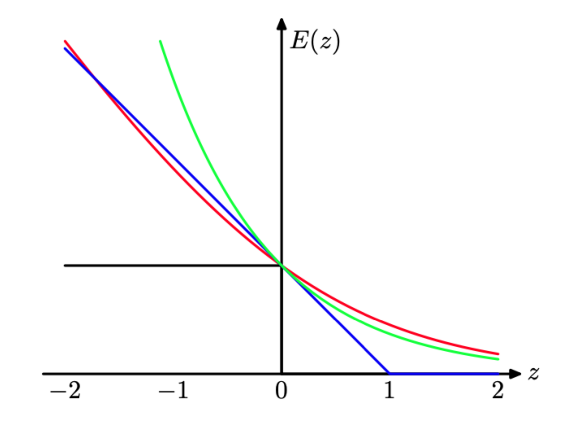

In [7]:
# 图14.3
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图14.3.png')
plt.axis('off')
ax.imshow(d)


 
图 14.3 指数误差函数（绿色）、缩放的交叉熵误差函数（红色）以及支持向量机使用的铰链误差函数（蓝色）和误分类误差函数（黑色）的图像。注意，对于$ z = ty(x) $的较大的负值，交叉熵误差函数给出了一个线性增长的惩罚，而指数误差函数给出了一个指数增长的惩罚。

我们看到，这两个函数都可以看成对理想误分类误差函数的连续近似。指数误差的一个优点是它的顺序最小化会得到简单的AdaBoost方法。然而，一个缺点是，与交叉熵误差函数相比，它对负的$ ty(x) $的惩罚较大。特别地，我们看到对于$ ty $的很大的值，交叉熵随着$ \vert ty \vert $线性增长，而指数误差随着$ \vert ty \vert $指数增长。因此指数误差函数对于异常点和误分类的数据点并不鲁棒。交叉熵误差函数和指数误差函数的另一个区别是后者无法表示为任何具有良好定义的概率模型的似然函数。此外，指数误差无法推广到具有$ K > 2 $个类别的分类问题，这再次与概率模型的交叉熵相反，它可以很容易地推广，得到(4.108)。

将提升方法表示为指数误差下的可加性模型的最优化(Friedman et al.， 2000)引出了一大类与提升方法相似的算法，包括对多类问题的推广，方法是使用其他的误差函数。它也引出了对于回归问题的推广(Friedman， 2001)。如果我们考虑回归问题的平方和误差函数，那么形如(14.21)的可加性模型的顺序最小化仅仅涉及到将新的分类器根据前一个模型的残留误差$ t_n − f_{m−1}(x_n) $进行调节。然而，正如我们已经注意到的那样，平方和误差函数对于异常点不健壮。这个问题可以通过将绝对偏差$ |y − t| $应用到提升方法中的方式得到解决。图14.4给出了这两个误差函数的对比。
 

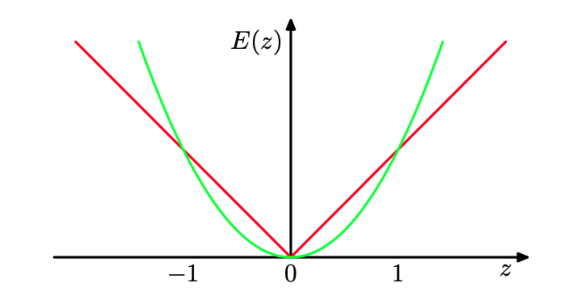

In [8]:
# 图14.4
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图14.4.png')
plt.axis('off')
ax.imshow(d)


图 14.4 平方误差（绿色）和绝对误差（红色）的对比。图中展示了后者为较大的误差赋予较低的重视程度，从而后者对于异常点和误分类的点更加健壮。




# 14.4 基于树的模型

有许多简单但广泛使用的模型，它们将输入空间划分为超立方体区域，超立方体的边与坐标轴对齐，然后为每个区域分配一个简单的模型（例如，一个常数）。这些模型可以被看成一种模型组合方法，其中只有一个模型对于输入空间中任意给定点的预测起作用。给定一个新的输入x，选择一个具体的模型的过程可以由一个顺序决策的过程描述，这个过程对应于对一个二叉树（每个节点划分为两个分支的树）的遍历。这里，我们关注一个特定的基于树的框架，被 称为分类与回归树（classification and regression tree），或者CART（Breiman et al.， 1994），虽 然还有很多其他的变体，例如ID3和C4.5（Quinlan， 1986; Quinlan， 1993）。

图14.5和图14.6给出了对输入空间进行递归二分的例子，以及对应的树结构。

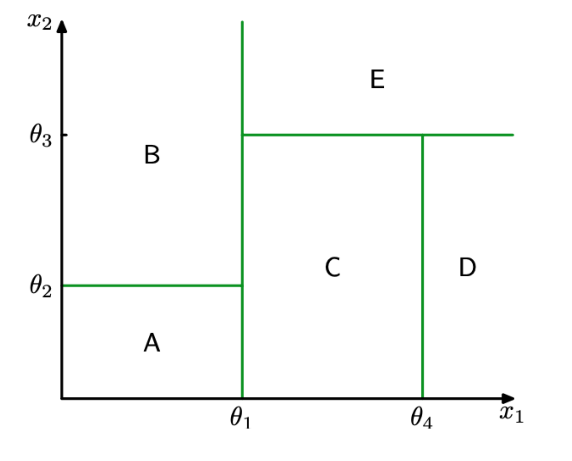

In [9]:
# 图14.5
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图14.5.png')
plt.axis('off')
ax.imshow(d)


 
图 14.5 二维输入空间使用与坐标轴平行的边界被划分为了五个区域。

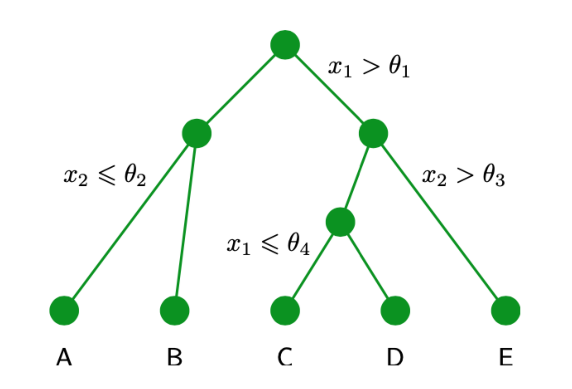

In [10]:
# 图14.6
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图14.6.png')
plt.axis('off')
ax.imshow(d)


 
图 14.6 对应于图14.5的输入空间的划分的二叉树。


在这个例子中，第一步根据$ x_1 \leq \theta_1 $或$ x_1 > \theta_1 $，将输入空间划分为两个区域，其中$ \theta_1 $是一个模型参数。这创建了两个子区域，每个区域之后可以独立地进行划分。例如，区域$ x_1 \leq \theta_1 $进一步根据$ x_2 \leq \theta_2 $或$ x_2 > \theta_2 $进行进一步划分，得到的区域被记作$ A $和$ B $。递归的过程可以用图14.6给出的二叉树的遍历进行描述。对于任意新的输入$ x $，我们确定它所属区域的方法是，从树顶端的根结点开始，根据每个结点的决策准则，沿着路径向下走到具体的叶结点。注意，这种决策树不 是概率图模型。

在每个区域内，有一个单独的模型预测目标变量的值。例如，在回归问题中，我们简单地在每个区域内预测一个常数，或者在分类问题中，我们将每个区域分配为一个具体的类别。基于树的模型的一个关键的性质是模型可以由人类表述，因为模型对应于作用在输入变量上的一个二元决策序列。这使得模型在例如医疗诊断领域很流行。例如，为了预测一个病人的疾病，我 们可以首先问“病人的体温是否大于某个阈值?”。如果回答是肯定的，那么我们可以问“病人的 血压是否低于某个阈值?”。然后树的每个叶结点都与一个具体的诊断相关联。

为了从一个训练数据集里学习到这样的一个模型，我们必须确定树的结构，包括在每个结点处选择哪个输入变量构成划分准则，以及用于划分的阈值参数\thetai的值。我们也必须确定每个区域内的预测变量的值。

首先考虑一个回归问题，其中我们的目标是从输入变量$ D $维向量$ x = (x_1,...,x_D)^T $中预测单一的目标变量$ t $的值。训练数据由输入向量$ {x_1,...,x_N} $以及对应的连续标签$ {t_1,...,t_N} $组成。如果输入空间的划分给定，并且我们最小化平方和误差函数，那么在任意给定区域的预测变量的最优值就是落在哪个区域的数据点的$ t_n $值的平均。

现在考虑如何确定决策树的结构。即使对于结点数量固定的树，确定最优结构（包括每次划分使用的输入变量以及对应的阈值）来最小化平方和误差函数的问题通常在计算上是不可行的，因为可能的组合数量相当大。相反，我们通常使用贪心的最优化。从对应于整个输入空间的一个单独的根结点开始，然后通过每次添加一个结点的方式构建树。在每一步，输入空间中会有若干个可以切分的候选的区域，对应于向当前的树中添加一对叶结点。对于每个这种候选区域，我们要选择使用D个输入变量中的哪一个进行划分，以及阈值的大小。划分区域的选择以及输入变量和阈值的选择可以通过彻底搜索的方式高效地进行联合最优化。我们注意到，对于给定的划分变量和阈值的选择，预测变量的最优选择是数据的局部平均值，如前所述。对划 分变量的所有可能选择重复上述步骤，得到最小的平方和误差的一个划分变量被保留下来。

得到构建树的贪心策略之后，剩下的问题是如何停止添加结点。一个简单的方法是当残留误差的减小量低于某个阈值时停止。然而，我们通过实验发现，经常出现这样的情形：没有划分方式会使误差函数产生显著的减小，但是再进行几次划分之后，就会找到一个使误差函数显著减小的划分方式。因此，在实际应用中通常构建一个较大的树，使用基于与叶结点关联的数据点数量的停止准则，然后进行剪枝，生成最终的树。剪枝的过程基于的准则会在残留误差与模 型复杂度之间进行平衡。我们将剪枝开始时的树记作$ T_0 $，然后我们对于$ T \subset T_0 $，如果它能够通过从$ T_0 $剪枝（即通过合并对应区域来收缩内部结点）的方式被得到，那么它就被定义为$ T_0 $的一个子树。假设叶结点的索引为$ \tau = 1,...,|T| $，叶结点$ \tau $表示具有$ N_\tau $个数据点的区域$ R_\tau $，$ |T | $表示叶结点的总数。那么区域$ R_\tau $给出的最优的预测为
$ y_\tau = \frac{1}{N_\tau}\sum\limits_{x_n \in R_\tau} t_n \tag{14.29} $
它对于残留的平方和误差的贡献为
$ Q_\tau(T) = \sum\limits_{x_n \in R_\tau}{t_n - y_\tau}^2 \tag{14.30} $
从而剪枝准则为
$ C(T) = \sum\limits_{\tau = 1}^{|T|}Q_\tau(T) + \lambda|T| \tag{14.31} $
正则化参数$ \lambda $确定了整体的残留平方和误差与模型复杂度之间的折中，模型复杂度用叶结点的数量$ |T| $表示，它的值通过交叉验证的方式确定。

对于分类问题，树的构建和剪枝的过程很类似，区别在于平方和误差函数被替换为一个更合适的性能的度量。如果我们将$ p_{\tau k} $定义为区域$ R_\tau $中被分配到类别$ k $的数据点的比例，其中$ k = 1,...,K $，那么经常使用的两个度量是交叉熵
$ Q_\tau(T) = -\sum\limits_{k=1}^Kp_{\tau k}\ln p_{\tau k} \tag{14.32} $
以及基尼系数（Gini index）
$ Q_\tau(T) = \sum\limits_{k=1}^Kp_{\tau k}(1-p_{\tau k}) \tag{14.33} $
如果对于任意的$ k = 1,...,K $都有$ p_{\tau k} = 1 $，那么这两个量都等于0，此时对于所有$ j \neq k $都有$ p_{\tau j} = 0 $。如果对于所有的$ k = 1,...,K $都有$ p_{\tau k} = 1 / K $，那么这两个量都会达到最大值。这两个量倾向于让区域中属于同一个类别的数据点的比例较高。在构建树的过程中，与分类错误率相比，交叉熵和基尼系数是一个更好的度量，因为这两个量对于结点的概率更敏感。并且，与分类错误率不同，它们是可微的，因此更适合基于梯度的最优化方法。对于接下来对树的剪枝过 程，通常使用分类错误率。

像CART这种树模型的可以由人类进行表述这一性质通常被视为它的一个重要的优点。然而，在实际应用中，学习到的特定的树结构对于数据集的细节非常敏感，从而训练集的一个微 小的改变就会产生一个相当不同的划分集合（Hastie et al.， 2001）。

本节讨论的这种基于树的方法有一些其他的问题。一个问题是，划分边界是与特征空间的坐标轴对齐的，这相当不好。例如，为了将最优边界与坐标轴成45度角的两个类别划分开，我们需要相当多的与坐标轴平行的划分，这个数量要远大于一个单一的不与坐标轴平行的划分的数量。此外，决策树中的划分是硬划分，从而输入空间中的每个区域与一个叶结点模型关联，并且只与一个叶结点模型关联。最后一个问题在解决回归问题时相当严重，其中我们通常的目标是对光滑的函数建模，但是树模型生成了分段常数的预测，划分的边界是不连续的。



# 14.5 条件混合模型

我们已经看到，标准的决策树被限制为对输入空间的硬的、与坐标轴对齐的划分。这些限制可以通过引入软的、概率形式的划分的方式得到缓解，这些划分是所有输入变量的函数，而不仅仅是某个输入变量的函数。这样做的代价是它的直观意义的消失。如果我们也给叶结点的模型赋予一个概率的形式，那么我们就得到了一个纯粹的概率形式的基于树的模型，被称为专家层次混合（hierarchical mixture of experts），将在14.5.3节讨论。

另一种得到专家层次混合模型的方法是从标准的非条件密度模型（例如高斯分布）的概率混合开始，将分量概率密度替换为条件概率分布。这里，我们考虑线性回归模型的混合（14.5.1 节）以及logistic回归模型的混合（14.5.2节）。在最简单的情况下，混合系数与输入变量无关。如果我们进行进一步的泛化，使得混合系数同样依赖于输入，那么我们就得到了专家混合（mixture of experts）模型。最后，如果我们使得混合模型的每个分量本身都是一个专家混合模型，那么我们就得到了专家层次混合模型。

## 14.5.1 线性回归模型的混合

用概率形式表示线性回归模型的众多优点之一是它可以用作更复杂的概率模型的一个分量。例如，将表示线性回归模型的条件概率分布看成有向概率图中的一个结点，即可完成这件事。 这里，我们考虑一个简单的例子，对应于线性回归模型的混合，它是9.2节讨论的高斯混合模型的一个直接推广，推广到了条件高斯分布的情形。

因此，我们考虑$ K $个线性回归模型，每个模型都由自己的权参数$ w_k $控制。在许多应用中，比较合适的做法是对所有$ K $个分量使用一个共同的噪声方差，由精度参数$ \beta $控制，这正是我们这里讨论的情形。我们再次将注意力集中于单一目标变量$ t $，但是推广到多个输出是很容易的。如果我们将混合系数记作$ \pi_k $，那么混合概率分布可以写成
$ p(t|\theta) = \sum\limits_{k=1}^K\pi_k\mathcal{N}(t|w_k^T\phi,\beta^{-1}) \tag{14.34} $
其中$ \theta $表示模型中所有可调节参数的集合，即$ W = {w_k}, \pi = {\pi_k} $以及$ \beta $。给定一组观测数据集$ {\phi_n, t_n} $，这个模型的对数似然函数的形式为
$ \ln p(t|\theta) = \sum\limits_{n=1}^N\ln\left(\sum\limits_{k=1}^K\pi_k\mathcal{N}(t_n|w_k^T\phi_n,\beta^{-1})\right) \tag{14.35} $
其中$ t = (t_1,...,t_N)^T $表示目标变量组成的向量。
为了最大化这个似然函数，我们可以再次使用EM算法。可以证明它是9.2节讨论的无条件高斯混合模型的EM算法的一个简单推广。于是我们可以基于我们对无条件混合分布的经验构造模型，引入一组二值潜在变量$ Z = {z_n} $，其中$ z_{nk} \in {0, 1} $，其中对于每个数据点$ n $，所有的$ k = 1,...,K $中只有一个元素为1，其余元素都等于0。等于1的元素表示哪个混合分布用于生成数据点。潜在变量与观测变量的联合概率分布可以用图14.7的图模型表示。

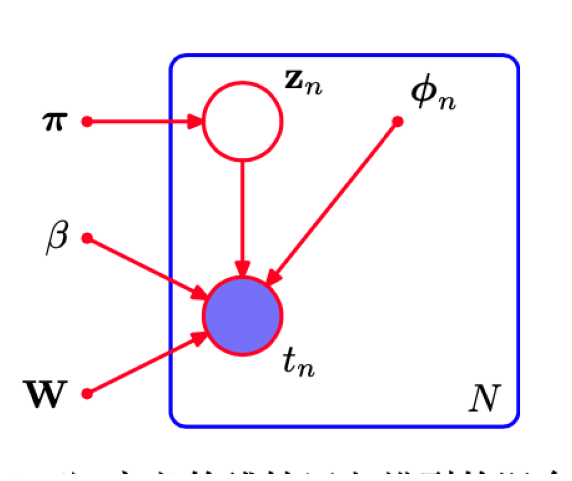

In [11]:
# 图14.7
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图14.7.png')
plt.axis('off')
ax.imshow(d)

图 14.7 表示由公式（14.35）定义的线性回归模型的混合模型的概率有向图。

这样，完整数据的对数似然函数的形式为
$ \ln p(t,Z|\theta) = \sum\limits_{n=1}^K\sum\limits_{k=1}^Kz_{nk}\ln{\pi_k\mathcal{N}(t_n|w_k^T\phi_n,\beta^{-1})} \tag{14.36}
$
EM算法在开始时，首先选择模型参数的初始值$ \theta^{old} $。在E步骤中，这些参数用于计算每个数据点$ n $的每个分量$ k $的后验概率分布或者“责任”，结果为
$ \gamma_{nk} = \mathbb{E}[z_{nk}] = p(k|\phi_n,\theta^{old}) = \frac{\pi_k\mathcal{N}(t_n|w_k^T\phi_n,\beta^{-1})}{\sum\limits_j\pi_j\mathcal{N}(t_n|w_j^T\phi_n,\beta^{-1})} \tag{14.37} $
然后，“责任”被用于确定完整数据对数似然函数关于后验概率分布$ p(Z|t, \theta^{old}）$的期望，形式为
$ Q(\theta,\theta^{old}) = \mathbb{E}Z[\ln p(t,Z|\theta)] = \sum\limits{n=1}^N\sum\limits_{k=1}^K\gamma_{nk}{\ln\pi_k + \ln\mathcal{N}(t_n|w_k^T\phi_n,\beta^{-1})} $
在M步骤中，我们关于$ \theta $最大化函数$ Q(\theta, \theta^{old}) $，保持$ \gamma_{nk} $不变。对于关于混合系数$ \pi_k $的最优化， 我们需要考虑限制条件$ \sum_k\pi_k = 1 $ 这使用拉格朗日乘数法即可完成，得到了$ \pi_k $的M步骤重估计方程，形式为
$ \pi_k = \frac{1}{N}\sum\limits_{n=1}^N\gamma_{nk} \tag{14.38} $
注意，这个函数形式与公式（9.22）给出的无条件的简单高斯混合的对应结果形式相同。

接下来，考虑关于第$ k $个线性回归模型的参数向量$ w_k $的最大化。代入高斯分布的表达式，我们看到$ Q(\theta, \theta^{old}) $关于参数向量$ w_k $的函数形式为
$ Q(\theta,\theta^{old}) = \sum\limits_{n=1}^N\gamma_{nk}\left{-\frac{\beta}{2}(t_n - w_k^T\phi_n)^2\right} + const \tag{14.39} $
其中常数项包含来自$ j \neq k $的其他权向量$ w_j $的贡献。注意，我们最大化的量类似于单一线性回归模型的标准平方和误差函数（3.12）的负对数，但是包含了责任项$ \gamma_{nk} $。这代表了加权最小平方（weighted least squares）问题，其中对应于第$ n $个数据点的项带有一个加权系数$ \beta\gamma_{nk} $，它可以 被看成每个数据点的有效精度。我们看到，混合模型中的每个分量线性回归模型由自身的参数向量$ w_k $控制，在M步骤中使用整个数据集分别进行调节，但是每个数据点$ n $由责任项$ \gamma_nk $加权，它表示模型$ k $对这个数据点的作用。令（14.39）关于$ w_k $的导数等于0，可得
$ 0 = \sum\limits_{n=1}^N\gamma_{nk}(t_n - w_k^T\phi_n)\phi_n \tag{14.40} $
它可以用矩阵的记号表示为
$ p = \Phi^TR_k(t - \Phi w_k) \tag{14.41} $
其中$ R_k = diag(\gamma_{nk}) $是一个$ N \times N $的对角矩阵。解出$ w_k $，我们有
$ w_k = (\Phi^TR_k\Phi)^{-1}\Phi^TR_kt \tag{14.42} $
它表示一组修改过的规范方程，对应于加权的最小平方问题，与logistic回归问题中得到的结果（4.99）具有相同的形式。注意，在每个E步骤之后，矩阵$ R_k $会发生变化，因此我们在后续M步骤中必须重新解规范方程。



最后，我们关于$ \beta $最大化$ Q(\theta, \theta^{old}) $。只保留依赖于$ \beta $的项，函数$ Q(\theta, \theta^{old}) $可以写成
$ Q(\theta, \theta^{old}) = \sum\limits_{n=1}^N\sum\limits_{k=1}^K\gamma_{nk}\left{\frac{1}{2}\ln\beta - \frac{\beta}{2}(t_n - w_k^T\phi_n)^2\right} \tag{14.43} $
令它关于$ \beta $的导数等于0，整理，我们得到了$ \beta $的M步骤方程，形式为
$ \frac{1}{\beta} = \frac{1}{N}\sum\limits_{n=1}^N\sum\limits_{k=1}^K\gamma_{nk}(t_n - w_k^T\phi_n)^2 \tag{14.44} $
在图14.8中，我们使用了一个简单的例子来说明这个EM算法。

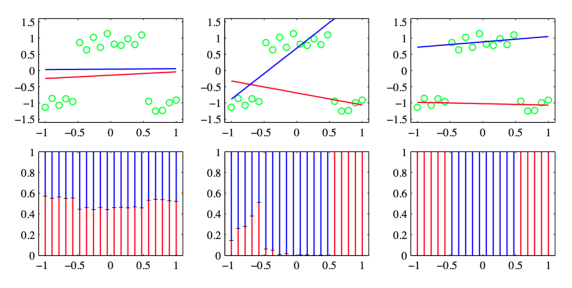

In [12]:
# 图14.8
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图14.8.png')
plt.axis('off')
ax.imshow(d)


 
图 14.8 人工生成的数据的例子，用绿色点表示，具有一个输入变量$ x $和一个输出变量$ t $。同时画出了两个线性回归模型的混合，它的均值函数$ y(x, w_k) $用蓝线和红线表示，其中$ k \in {1, 2} $。上方三张图表示初始配置(左图)、运行了30轮EM迭代的结果(中图)以及运行了50轮EM迭代的结果(右图)。这里，$ \beta $被初始化为目标值集合的真实方差的倒数。下方三张图将每个数据点的对应的责任项用竖直线表示，其中蓝色线段的长度表示那个数据点的蓝色线的后验概率(红色线段的含义与之类似)。

这个例子中，我们根据数据集来调整由两条直线组成的混合模型，数据集有一个输入变量$ x $和一个目标变量$ t $。预测密度（14.34）如图14.9所示，使用了从EM算法中得到的收敛的参数值，对应于图14.8的右图。

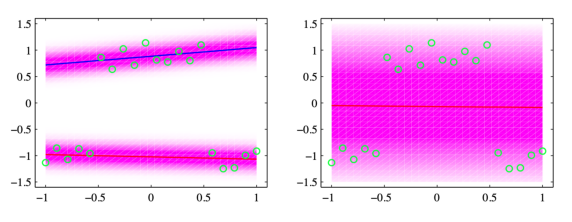

In [13]:
# 图14.9
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图14.9.png')
plt.axis('off')
ax.imshow(d)


 
图 14.9 左图表示对应于图14.8的收敛解的预测条件概率密度。对数似然函数的值为-3.0。在特定的$ x $处，穿过图像的垂直切片表示条件概率分布$ p(t|x) $，可以看到它是双峰的。右图给出了使用最大似然方法用同样的数据集拟合的单一线性回归模型。模型的对数似然函数值较小，为-27.6。

图中同时给出的是拟合单一的线性回归模型的结果，它给出了一个单峰的预测密度。我们看到，混合模型可以更好地表示数据分布，这一点通过更高的似然函数值反映出来。然而，混合模型也将相当大的概率质量分配到了没有数据的区域，因为它的预测分布对于x的所有值来说是双峰的。这个问题可以这样解决：将模型扩展，使得混合系数本身是$ x $的一个函数，这就产生了5.6 节讨论的混合密度网络模型，以及14.5.3节讨论的专家层次混合模型。



# 14.6 logistic模型的混合

由于线性回归模型定义了给定输入变量的条件下目标变量的一个条件概率分布，因此很容易将其用作混合模型中的分量分布，从而与单一的logistic回归模型相比，可以表示更丰富的一类 条件概率分布。这个例子涉及到对本书前面章节讨论的思想的一个直接组合，有助于帮助读者巩固这些知识。

对于$ K $个logistic回归模型来说，目标变量的条件概率分布为
$ p(t|\phi,\theta) = \sum\limits_{k=1}^K\pi_ky_k^t[1-y_k]^{1-t} \tag{14.45} $
其中$ \phi $是特征向量，$ y_k = \sigma(w_k^T\phi) $是分量$ k $的输出，$ \theta $表示可调节参数，即$ {\pi_k} $和$ {w_k} $。
现在假设我们有一个数据集$ {\phi_n, t_n} $。从而对应的似然函数为
$ p(t|\theta) = \prod\limits_{n=1}^N\left(\sum\limits_{k=1}^K\pi_ky_{nk}^{t_n}[1-y_{nk}]^{1-t_n}\right) \tag{14.46} $
其中$ y_{nk} = \sigma(w_k^T\phi_n), t = (t_1,...,t_N)^T $。我们可以使用EM算法迭代地最大化这个似然函数。这涉及到引入潜在变量$ z_{nk} $，它对应于每个数据点$ n $的用1-of-K方式编码的二值指示器变量。完整数据的似然函数为
$ p(t,Z|\theta) = \prod\limits_{n=1}^N\prod\limits_{k=1}^K{\pi_ky_{nk}^{t_n}[1-y_{nk}]^{1-t_n}}^{z_{nk}} \tag{14.47} $
其中$ Z $是潜在变量矩阵，元素为$ z_{nk} $。我们通过选择模型参数的一个初始值$ \theta^{old} $来初始化EM算法。之后在E步骤中，我们使用这些参数值来计算每个数据点$ n $的分量$ k $的后验概率，形式为
$ \gamma_{nk} = \mathbb{E}[z_{nk}] = p(k|\phi_n, \theta^{old}) = \frac{\pi_ky_{nk}^{t_n}[1-y_{nk}]^{1-t_n}}{\sum\limits_j\pi_jy_{nj}^{t_n}[1-y_{nj}]^{1-t_n}} \tag{14.48} $
这些责任项然后用于寻找完整数据对数似然函数的期望，它作为\theta的一个函数，形式为
$ \begin{eqnarray} Q(\theta，\theta^{old}) &=& \mathbb{E}Z[\ln p(t,Z|\theta)] \ &=& \sum\limits{n=1}^N\sum\limits_{k=1}^K\gamma_{nk}{\ln\pi_k + t_n\ln y_{nk} + (1-t_n)\ln(1-y_{nk})} \tag{14.49} \end{eqnarray} $
M步骤涉及到关于$ \theta $最大化这个函数，保持$ \theta^{old} $不变，从而$ \gamma_{nk} $保持不变。关于$ \pi_k $的最大化可以使用通常的方式进行，引入拉格朗日乘数来强制满足$ \sum_k\pi_k = 1 $的限制，得到下面的熟悉的结果
$ \pi_k = \frac{1}{N}\sum\limits_{n=1}^N\gamma_{nk} \tag{14.50} $
为了确定$ {w_k} $，我们注意到$ Q(\theta,\theta^{old}) $由一组下标为$ k $项的求和式组成，它只依赖于向量$ w_k $中的一个，因此不同的向量在EM算法的M步骤中可以独立进行优化。换句话说，不同的分量只通过责任项产生相互作用，它在M步骤中是固定的。注意，M步骤没有封闭解，必须使用例如迭代重加权最小平方（IRLS）算法迭代地求解。对于向量$ w_k $的梯度和Hessian矩阵为
$ \begin{eqnarray} \nabla_kQ &=& \sum\limits_{n=1}^N\gamma_{nk}(t_n - y_{nk})\phi_n \tag{14.51} \\ H_k = -\nabla_k\nabla_kQ = \sum\limits_{n=1}^N\gamma_{nk}y_{nk}(1-y_{nk})\phi_n\phi_n^T \tag{14.52} \end{eqnarray} $
其中$ \nabla_k $表示关于$ w_k $的梯度。对于固定的$ \gamma_{nk} $，梯度和Hessian矩阵独立于$ j \neq k $的$ {w_j} $，因此我们可以使用IRLS算法分别对每个$ w_k $求解。因此分量$ k $的M步骤方程仅仅对应于使用数据集调整一个单独的logistic回归模型，其中数据点$ n $携带权值$ \gamma_{nk} $。图14.10给出了logistic回归模型的混合模型应用于简单的分类问题中的例子。

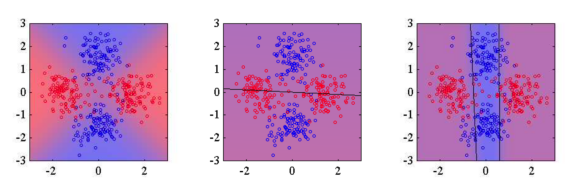

In [14]:
# 图14.10
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图14.10.png')
plt.axis('off')
ax.imshow(d)


 
图 14.10 ogistic回归模型的混合的例子。左图给出了从两个类别中抽取的数据点，两个类别分别用红色和蓝色表示，其中背景颜色（从纯红变化到纯蓝）表示模型标签的真实概率。中图表示使用最大似然方法拟合单一的logistic回归模型的结果，其中背景颜色表示类别标签的对应的概率。由于颜色几乎是均匀的紫色，因此我们看到模型在输入空间中的大部分区域都会分配一个近似为0.5的概率。右图给出了使用两个logistic回归模型的混合模型进行调节的结果，它对于蓝色类别中的许多点，都会给正确的标签赋予高得多的概率。

将这个模型推广为softmax模型的混合模型来处理多类问题是很容易的。



## 14.6.1 专家混合

在14.5.1节，我们考虑了线性回归模型的混合，在14.5.2节，我们讨论了线性分类器的类似的混合。虽然这些简单的混合扩展了线性模型的灵活程度，包含了更复杂的（例如多峰的）预测分布，但是它们仍然具有很大的局限性。我们可以进一步增强这些模型的能力，方法是使得混 合系数本身是输入变量的函数，即
$ p(t|x) = \sum\limits_{k=1}^K\pi_k(x)p_k(t|x) \tag{14.53} $
这被称为专家混合（mixture of experts）模型（Jacobs et al.， 1991），其中混合系数$ \pi_k(x) $被称为门函数（gating function），各个分量密度$ p_k(t|x) $被称为专家（expert）。属于背后的思想是，不同的分量可以对输入空间的不同区域的概率分布进行建模（它们是在它们自己的区域做预测的“专家”），门函数确定哪个分量控制哪个区域。

门函数$ \pi_k(x) $必须满足混合系数通常的限制，即$ 0 \leq \pi_k(x) \leq 1 $以及$ \sum_k\pi_k(x) = 1 $。因此它们可以通过例如线性softmax函数（4.104）和（4.105）表示。如果专家也是线性（回归或分类）模型，那么整个模型可以使用EM算法高效地调节，在M步骤中要使用迭代重加权最小平方（Jordan and Jacobs， 1994）。

由于门函数和专家函数使用了线性模型，因此这样的模型仍然有很大的局限性。一个更加灵活的模型时使用多层门函数，得到了专家层次混合（hierarchical mixture of experts）模型或HME模型（Jordan and Jacobs， 1994）。为了理解这个模型的结构，假设一个混合分布，它的每个分量本身都是一个混合分布。对于无条件的混合分布，层次混合简单地等价于一个普通的混合分布。然而，当混合系数与输入相关时，层次模型就变得不普通了。HME模型也可以被看成14.4节讨论的决策树的概率版本，并且与之前一样可以通过最大似然的方式使用EM算法以 及M步骤中的IRLS算法高效计算。Bishop and Svensen (2003)基于变分推断提出了HME的一个贝叶斯方法。

我们这里不会详细讨论HME。然而，值得指出的一点是，它与5.6节讨论的混合密度网络（mixture density network）有着密切的联系。专家混合的主要的优点在于它可以通过EM算法最优化，其中每个混合分量以及门函数的M步骤涉及到一个凸优化（虽然整体的最优化不是凸优化）。相反，混合密度网络方法的一个优势是分量密度和混合系数共享神经网络的隐含单元。此外，与专家层次混合相比，在混合密度网络中，对输入空间的划分更加放松，因为划分不仅是软划分，并且不限于与坐标轴平行，而且还可以是非线性的。

